<a href="https://colab.research.google.com/github/AbdElRahmanFarhan/box_semantic_segmentation/blob/main/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install pycocotools
!pip install coco-eval

In [37]:
import zipfile

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [38]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/train2017')
val_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/val2017')
train_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_train2017.json')
val_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_val2017.json')
torch.cuda.empty_cache()

In [39]:
import torch
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from PIL import Image
from torchvision.tv_tensors import Mask
from torchvision.transforms.functional import to_tensor
from skimage.draw import polygon as sk_polygon


class OSCDDataset(CocoDetection):
    def __init__(self, img_folder, ann_file):
        super().__init__(img_folder, ann_file, transforms=None)

    def __len__(self) -> int:
       return super().__len__()

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        if anns:
          labels = []
          areas = []
          iscrowd = []
          masks = []
          boxes = []
          ids = []
          for ann in anns:
              x, y, w, h = list(map(int, ann['bbox']))
              boxes.append([x, y, x + w, y + h])
              labels.append(ann['category_id'])
              areas.append(ann['area'])
              iscrowd.append(ann['iscrowd'])
              mask = self.get_mask(ann['segmentation'], img.size[1], img.size[0])
              masks.append(mask)
              ids.append(ann['id'])

          labels = torch.tensor(labels, dtype=torch.int64)
          areas = torch.tensor(areas, dtype=torch.float32)
          iscrowd = torch.tensor(iscrowd, dtype=torch.uint8)
          boxes = torch.tensor(boxes, dtype=torch.int64)
          masks = torch.stack(masks, dim=0)
          ids = torch.tensor(ids, dtype=torch.int64)
          img_id = torch.tensor(ann['image_id'], dtype=torch.int64)

          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": img_id,
              "ids": ids,
              "area": areas, # TODO: is it area or areas
              "iscrowd": iscrowd,
              "masks": Mask(masks),
          }
        else:
          target = {}
        img = to_tensor(img)
        return img, target

    def get_mask(self, segmentation, height, width):
        mask = torch.zeros((height, width), dtype=torch.bool)
        poly_x = segmentation[0][::2]
        poly_y = segmentation[0][1::2]
        rr, cc = sk_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1
        return mask


In [40]:
train_dataset = OSCDDataset(train_folder, train_annotation)
val_dataset = OSCDDataset(val_folder, val_annotation)
train_dataset_small = torch.utils.data.Subset(train_dataset, list(range(100)))
val_dataset_small = torch.utils.data.Subset(val_dataset, list(range(10)))

loading annotations into memory...
Done (t=1.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [41]:
def collate_fn(batch):
    images, targets = [], []
    for (image, target) in batch:
      if not target:
        continue
      else:
        images.append(image)
        targets.append(target)
    return images, targets

In [42]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True)

train_loader_small = DataLoader(train_dataset_small, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
val_loader_small = DataLoader(val_dataset_small, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True)

In [43]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [45]:
import math
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler

def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, is_training):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Valid")  # Initialize a progress bar
    batch_counter = 0
    for batch_id, (images, targets) in enumerate(dataloader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(targets) == 0:
          continue
        batch_counter += 1
        with autocast(device.type):
            if is_training:
                losses = model(images, targets)
            else:
                with torch.no_grad():
                    losses = model(images, targets)

            loss = sum([loss for loss in losses.values()])

        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item

        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_counter+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

    progress_bar.close()

    return epoch_loss / (batch_counter + 1)

In [46]:
def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs):

    scaler = GradScaler()
    for epoch in tqdm(range(epochs), desc="Epochs"):

        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, is_training=True)

        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, is_training=False)

In [48]:
from torch.optim import AdamW

loader_to_train = train_loader_small
loader_to_val = val_loader_small
epochs = 10
lr = 5e-4
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(loader_to_train))
model.to(device)
train_loop(model=model,
           train_dataloader=loader_to_train,
           valid_dataloader=loader_to_val,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=device,
           epochs=epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Valid:   0%|          | 0/10 [00:00<?, ?it/s]

In [56]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(dataset_folder, 'model', f'model_{timestamp}.pth')
torch.save(model.state_dict(), model_path)

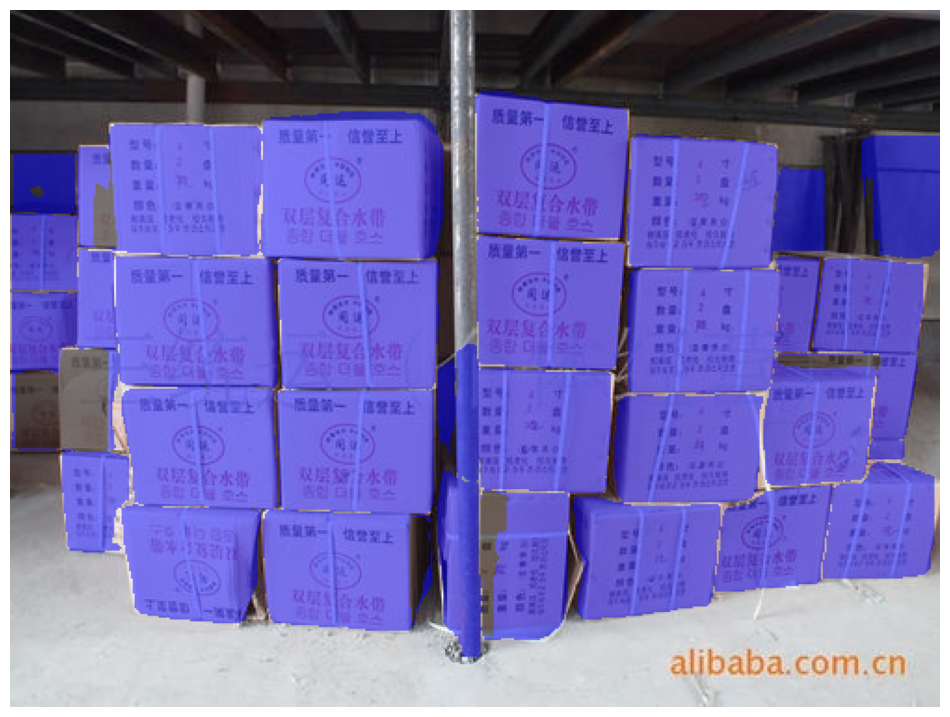

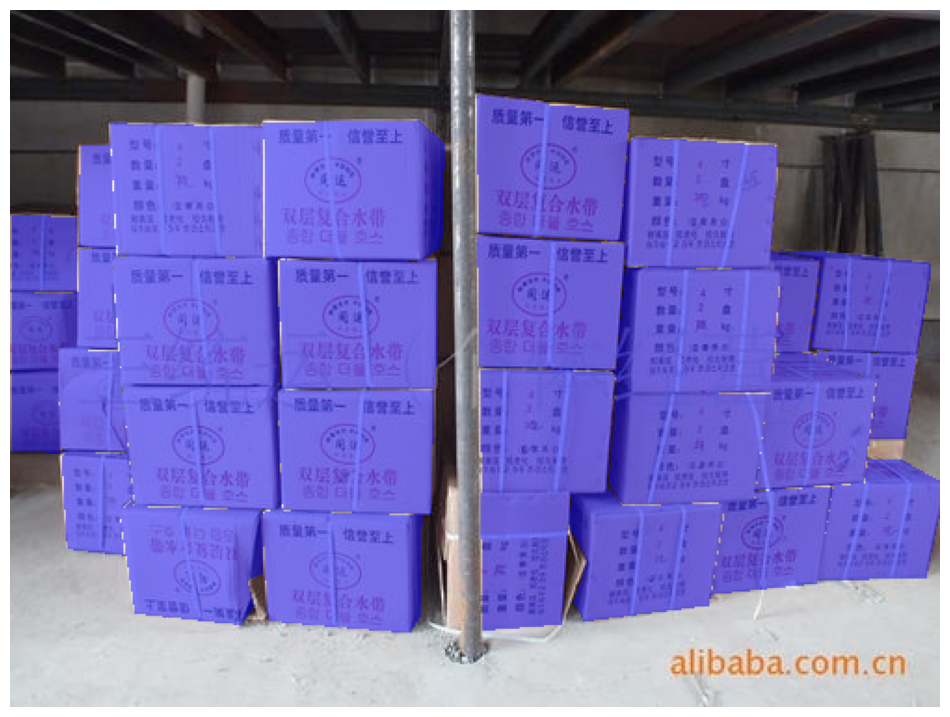

In [50]:
model.eval()
images, targets = next(iter(val_loader))
images = [image.to(device) for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
preds = model(images)
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

images, targets = next(iter(val_loader))
images = [image.to(device) for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
preds = model(images)
img = images[0]

pred = preds[0]
pred_boxes = pred["boxes"]
pred_labels = pred["labels"]

# plt_img = draw_bounding_boxes(img, pred_boxes, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
plt_img = draw_segmentation_masks(img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

target = targets[0]
target_boxes = pred["boxes"]
target_labels = pred["labels"]
# plt_img = draw_bounding_boxes(img, target_boxes, colors="red")
masks = (target["masks"] > 0.7).squeeze(1)
plt_img = draw_segmentation_masks(img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

In [53]:
from coco_eval import CocoEvaluator
import numpy as np
import pycocotools.mask as mask_util

def prepare_for_coco_segmentation(predictions, targets):
    coco_results = []
    for prediction, target in zip(predictions, targets):
        masks = prediction["masks"]
        masks = masks > 0.5
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()
        rles = [
            mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
        ]
        for rle in rles:
            rle["counts"] = rle["counts"].decode("utf-8")
        coco_results.extend(
            [
                {
                    "image_id": target["image_id"].item(),
                    "category_id": labels[k],
                    "segmentation": rle,
                    "score": scores[k],
                }
                for k, rle in enumerate(rles)
            ]
        )
    return coco_results

def evaluate(model, data_loader, device):
    model.eval()
    epoch_loss = torch.zeros(1).to(device)
    coco_eval = CocoEvaluator(data_loader.dataset.coco, ['segm'])
    for i, (images, targets) in enumerate(data_loader):
      images = [image.to(device) for image in images]
      with torch.no_grad():
        predictions = model(images)
        predictions = [{k: v.to('cpu') for k, v in o.items()} for o in predictions]
        coco_results = prepare_for_coco_segmentation(predictions, targets)
        coco_eval.update(coco_results)
        break
    coco_eval.synchronize_between_processes()
    coco_eval.accumulate()
    return coco_eval

In [55]:
eval = evaluate(model, val_loader, device)
eval.summarize()

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 